<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [2]:
data.isna().sum()
#data['CustomerId'].duplicated().sum()


RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [3]:
data['Tenure'] = data['Tenure'].fillna(0)
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Импортируем библиотеки и сохраним датасет в переменную data. Выведем первые 5 строк на экран. Проверим на наличие пропусков, в столбце Tenure 900 выявляются пропусков, заменим их на значение 0 (позже попробуем заменить на медиану). 
Первые три столбца можно смело удалить, т.к. качество модели они не улучшат. 
Столбцы Geograph и Gender преобразуем с помощью OHE для обучения ЛР, т.к. они относятся к категориальному типу данных.
Столбец Exited с целевым признаком.

In [4]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
data_dum = pd.get_dummies(data, drop_first=True)
data_dum.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Методом get_dummies обработали столбцы с категориальными признакамию. Далее разобьем датасет на обучающую, проверочную и тестовую выборки в соотношении 3:1 стратифицируя по целевому признаку.

In [6]:
target = data_dum['Exited']
features = data_dum.drop('Exited', axis=1)

features, features_test, target, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345, stratify=target)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.3, random_state=12345, stratify=target)

display(features.shape)
display(features_test.shape)
display(target.shape)
display(target_test.shape)
display(features_valid.shape)
display(target_valid.shape)

(7500, 11)

(2500, 11)

(7500,)

(2500,)

(2250, 11)

(2250,)

Масштабируем столбцы c различающимся масштабом данных, уберем оповещение об ошибке методом pd.options.mode.chained_assignment

In [7]:
pd.options.mode.chained_assignment = None

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
StandardScaler(copy=True, with_mean=True, with_std=True)
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
display(features_test.head())
display(features_valid.head())
display(features_train.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7888,-0.590796,-0.771598,-1.458524,0.037375,-0.912868,1,0,-0.390593,0,0,0
1567,0.634146,1.360093,0.472362,0.609479,-0.912868,0,0,1.582280,0,0,1
8704,1.364994,0.294247,-0.814895,0.513659,0.799371,1,0,-1.642022,0,1,0
7244,-2.124547,-0.577808,0.794177,-1.234500,0.799371,1,0,0.382246,0,0,0
6466,0.273869,-0.674703,-0.171267,1.003775,-0.912868,1,1,0.305778,1,0,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5411,-0.096701,0.100457,-1.458524,-1.234500,0.799371,1,0,-1.567067,0,0,0
7140,0.531210,0.003562,0.472362,1.213124,-0.912868,0,0,1.445283,0,1,1
2072,0.942955,-0.287123,-0.171267,-1.234500,0.799371,1,1,1.571650,0,0,1
3613,0.129759,-1.352969,0.472362,1.535775,0.799371,1,1,0.127645,1,0,1
9530,0.160639,0.197352,0.472362,-1.234500,0.799371,0,0,1.158330,0,0,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
956,1.601748,0.391142,-1.458524,-1.234500,0.799371,0,1,-0.264009,0,1,0
8541,-0.045233,0.778722,0.150548,0.458372,0.799371,1,1,0.987269,0,1,1
8846,-0.827549,1.360093,-0.814895,-1.234500,0.799371,1,0,-1.265160,0,0,0
1270,0.747376,-0.868493,0.794177,0.614058,-0.912868,1,0,-1.488621,1,0,1
3526,1.519399,-0.868493,1.437805,-1.234500,0.799371,1,0,0.629624,0,0,0


## Исследование задачи

Попробуем обучить модели без учета взвешивания, начнем с обучающего дерева, далее обучающий лес и логистическая регрессия. Лучшие модели сохраним в переменных. Выведем Accuracy, Лучшую модель, соотношение ответов, матрицу ошибок, полноту, точность, f1_score для всех лучших моделей.

In [8]:
best_model = None
best_result = 0

for i in range(1,40):
    model = DecisionTreeClassifier(random_state=12345, max_depth=i)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = model.score(features_valid, target_valid) 
    if result > best_result:
        best_model = model
        best_result = model.score(features_valid, target_valid) 
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print('Лучшая модель:', best_model)
print('Соотношение ответов:', pd.Series(best_model.predict(features_valid)).value_counts(normalize = 1))
print('Матрица ошибок', confusion_matrix(target_valid, best_model.predict(features_valid)))
print('recall:', recall_score(target_valid, best_model.predict(features_valid)))
print('precision:', precision_score(target_valid, best_model.predict(features_valid)))
print('f1_score', f1_score(target_valid, best_model.predict(features_valid)))

Accuracy наилучшей модели на валидационной выборке: 0.8506666666666667
Лучшая модель: DecisionTreeClassifier(max_depth=5, random_state=12345)
Соотношение ответов: 0    0.909333
1    0.090667
dtype: float64
Матрица ошибок [[1751   41]
 [ 295  163]]
recall: 0.3558951965065502
precision: 0.7990196078431373
f1_score 0.49244712990936557


In [9]:
%%time
best_model_forest = None
best_result_forest = 0
for est in range(1, 40):
    for depth in range(1,10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        result = model.score(features_valid, target_valid) 
        if result > best_result_forest:
            best_model_forest = model 
            best_result_forest = model.score(features_valid, target_valid)  

print("Accuracy наилучшей модели на валидационной выборке:", best_result_forest, best_model_forest)
print('Соотношение ответов:', pd.Series(best_model_forest.predict(features_valid)).value_counts(normalize = 1))
print('Матрица ошибок', confusion_matrix(target_valid, best_model_forest.predict(features_valid)))
print('recall:', recall_score(target_valid, best_model_forest.predict(features_valid)))
print('precision:', precision_score(target_valid, best_model_forest.predict(features_valid)))
print('f1_score', f1_score(target_valid, best_model_forest.predict(features_valid)))

Accuracy наилучшей модели на валидационной выборке: 0.8555555555555555 RandomForestClassifier(max_depth=9, n_estimators=19, random_state=12345)
Соотношение ответов: 0    0.892889
1    0.107111
dtype: float64
Матрица ошибок [[1738   54]
 [ 271  187]]
recall: 0.40829694323144106
precision: 0.7759336099585062
f1_score 0.5350500715307582
CPU times: user 25.1 s, sys: 224 ms, total: 25.4 s
Wall time: 27.6 s


In [11]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
model.predict(features_valid)
print(model.score(features_valid, target_valid))
print('Соотношение ответов:', pd.Series(model.predict(features_valid)).value_counts(normalize = 1))
print('Матрица ошибок', confusion_matrix(target_valid, model.predict(features_valid)))
print('recall:', recall_score(target_valid, model.predict(features_valid)))
print('precision:', precision_score(target_valid, model.predict(features_valid)))
print('f1_score', f1_score(target_valid, model.predict(features_valid)))

0.8106666666666666
Соотношение ответов: 0    0.925333
1    0.074667
dtype: float64
Матрица ошибок [[1724   68]
 [ 358  100]]
recall: 0.2183406113537118
precision: 0.5952380952380952
f1_score 0.3194888178913738


Accuracy  у всех моделей высокий, но низкий f1_score говорит о том, что точность и полнота у нас страдают. Все показатели выведены на экран для лучших моделей.
Так же по матрицам ошибок видно, что модели стремятся давать ложнонегативные FN прогнозы(ошибки).
Попробуем проверить модели на адекватность- посмотрим на дисбаланс классов и обучим константную модель:

In [12]:
target_valid.value_counts(normalize = 1)

0    0.796444
1    0.203556
Name: Exited, dtype: float64

In [13]:
target_train.value_counts(normalize = 1)

0    0.79619
1    0.20381
Name: Exited, dtype: float64

In [14]:
target_pred_constant = pd.Series([0]*len(target))

print(accuracy_score(target, target_pred_constant)) 

0.7962666666666667


Accuracy константной модели близка к точности обученных раннее моделей.

## Борьба с дисбалансом

Ранее мы видели, что соотношение классов в целевой выборке примерно 4к1. Попробуем сбалансировать данные путем увеличения выборки, попробовал увеличить в 4,5,6 раз, лучшие результаты при 5кратном увеличении. 

In [15]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

print(target_upsampled.value_counts(normalize=1))

1    0.561385
0    0.438615
Name: Exited, dtype: float64


Попробуем обучить модели на новой выборке.

In [16]:
best_model = None
best_result = 0

for i in range(1,40):
    model = DecisionTreeClassifier(random_state=12345, max_depth=i)
    model.fit(features_upsampled, target_upsampled)
    predictions_valid = model.predict(features_valid)
    result = model.score(features_valid, target_valid) 
    if result > best_result:
        best_model = model
        best_result = model.score(features_valid, target_valid) 
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print('Лучшая модель:', best_model)
print('Соотношение ответов:', pd.Series(best_model.predict(features_valid)).value_counts(normalize = 1))
print('Матрица ошибок', confusion_matrix(target_valid, best_model.predict(features_valid)))
print('recall:', recall_score(target_valid, best_model.predict(features_valid)))
print('precision:', precision_score(target_valid, best_model.predict(features_valid)))
print('f1_score', f1_score(target_valid, best_model.predict(features_valid)))

Accuracy наилучшей модели на валидационной выборке: 0.8026666666666666
Лучшая модель: DecisionTreeClassifier(max_depth=17, random_state=12345)
Соотношение ответов: 0    0.798222
1    0.201778
dtype: float64
Матрица ошибок [[1572  220]
 [ 224  234]]
recall: 0.5109170305676856
precision: 0.5154185022026432
f1_score 0.5131578947368421


Показатели увеличились, но недостаточно

In [17]:

best_model_forest = None
best_result_forest = 0
for est in range(1, 40):
    for depth in range(1,10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_upsampled, target_upsampled) 
        result = model.score(features_valid, target_valid) 
        if result > best_result_forest:
            best_model_forest = model 
            best_result_forest = model.score(features_valid, target_valid)  

print("Accuracy наилучшей модели на валидационной выборке:", best_result_forest, best_model_forest)
print('Соотношение ответов:', pd.Series(best_model_forest.predict(features_valid)).value_counts(normalize = 1))
print('Матрица ошибок', confusion_matrix(target_valid, best_model_forest.predict(features_valid)))
print('recall:', recall_score(target_valid, best_model_forest.predict(features_valid)))
print('precision:', precision_score(target_valid, best_model_forest.predict(features_valid)))
print('f1_score', f1_score(target_valid, best_model_forest.predict(features_valid)))

Accuracy наилучшей модели на валидационной выборке: 0.8062222222222222 RandomForestClassifier(max_depth=9, n_estimators=30, random_state=12345)
Соотношение ответов: 0    0.715556
1    0.284444
dtype: float64
Матрица ошибок [[1483  309]
 [ 127  331]]
recall: 0.722707423580786
precision: 0.5171875
f1_score 0.6029143897996356


У модели случайного леса мы добились хорошего результата, значительно увеличись точность и полнота, f1_score 0.60.

In [18]:

model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_upsampled, target_upsampled)
model.predict(features_valid)
print(model.score(features_valid, target_valid))
print('Соотношение ответов:', pd.Series(model.predict(features_valid)).value_counts(normalize = 1))
print('Матрица ошибок', confusion_matrix(target_valid, model.predict(features_valid)))
print('recall:', recall_score(target_valid, model.predict(features_valid)))
print('precision:', precision_score(target_valid, model.predict(features_valid)))
print('f1_score', f1_score(target_valid, model.predict(features_valid)))

0.6493333333333333
Соотношение ответов: 0    0.542667
1    0.457333
dtype: float64
Матрица ошибок [[1112  680]
 [ 109  349]]
recall: 0.7620087336244541
precision: 0.3391642371234208
f1_score 0.4694014794889038


Логистическая регрессия показывает хорошие показатели полноты, но точность всего 0.3, что негативно влияет на показатель f1_score.
Можно попробовать поиграть с порогом, но как я понял, мы добьемся увеличения точности и снижения полноты, что в итоге не приведет увеличению f1_score.

<div class="alert alert-info">
<b>Попробуем изменить порог:
 </b></font>
</div>

In [19]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_upsampled, target_upsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.3, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, model.predict(features_valid))

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1_score = {:.4f}".format(
        threshold, precision, recall, f1))

Порог = 0.30 | Точность = 0.254, Полнота = 0.937, f1_score = 0.4694
Порог = 0.32 | Точность = 0.259, Полнота = 0.924, f1_score = 0.4694
Порог = 0.34 | Точность = 0.268, Полнота = 0.917, f1_score = 0.4694
Порог = 0.36 | Точность = 0.274, Полнота = 0.893, f1_score = 0.4694
Порог = 0.38 | Точность = 0.280, Полнота = 0.873, f1_score = 0.4694
Порог = 0.40 | Точность = 0.288, Полнота = 0.860, f1_score = 0.4694
Порог = 0.42 | Точность = 0.295, Полнота = 0.838, f1_score = 0.4694
Порог = 0.44 | Точность = 0.304, Полнота = 0.825, f1_score = 0.4694
Порог = 0.46 | Точность = 0.318, Полнота = 0.808, f1_score = 0.4694
Порог = 0.48 | Точность = 0.325, Полнота = 0.784, f1_score = 0.4694
Порог = 0.50 | Точность = 0.339, Полнота = 0.762, f1_score = 0.4694
Порог = 0.52 | Точность = 0.349, Полнота = 0.729, f1_score = 0.4694
Порог = 0.54 | Точность = 0.367, Полнота = 0.714, f1_score = 0.4694
Порог = 0.56 | Точность = 0.368, Полнота = 0.672, f1_score = 0.4694
Порог = 0.58 | Точность = 0.379, Полнота = 0.642

<div class="alert alert-info">
<b> f1 стоит на месте, полноста и точность обратно пропорционально изменяются
    
попробуем подобрать параметры через gridsearch
 </b></font>
</div>

In [20]:
C = np.logspace(0, 4, 50)
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga']
hyperparameters = dict(C=C, penalty=penalty, solver=solver)
logistic = LogisticRegression()
gridsearch = GridSearchCV(logistic, hyperparameters, scoring='f1', cv=10)

best_model_grid = gridsearch.fit(features_upsampled, target_upsampled)
best_params = gridsearch.best_params_
model = LogisticRegression(**best_params, max_iter=100)
fit_lr = model.fit(features_upsampled, target_upsampled)
pred = fit_lr.predict(features_valid)
print(classification_report(target_valid, pred))
print('f1_score', f1_score(target_valid, pred))

              precision    recall  f1-score   support

           0       0.91      0.62      0.74      1792
           1       0.34      0.76      0.47       458

    accuracy                           0.65      2250
   macro avg       0.62      0.69      0.60      2250
weighted avg       0.79      0.65      0.68      2250

f1_score 0.4694014794889038


## Тестирование модели

Протестируем модель RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=9)

In [21]:
%%time
model = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=9) 
model.fit(features_upsampled, target_upsampled) 
result = model.score(features_test, target_test) 


print("Accuracy наилучшей модели на валидационной выборке:", result)
print('Соотношение ответов:', pd.Series(model.predict(features_test)).value_counts(normalize = 1))
print('Матрица ошибок', confusion_matrix(target_test, model.predict(features_test)))
print('recall:', recall_score(target_test, model.predict(features_test)))
print('precision:', precision_score(target_test, model.predict(features_test)))
print('f1_score', f1_score(target_test, model.predict(features_test)))
print('AUC-ROC финальной модели:', roc_auc_score(target_test, model.predict(features_test)))

Accuracy наилучшей модели на валидационной выборке: 0.8124
Соотношение ответов: 0    0.7144
1    0.2856
dtype: float64
Матрица ошибок [[1654  337]
 [ 132  377]]
recall: 0.7406679764243614
precision: 0.5280112044817927
f1_score 0.616516762060507
AUC-ROC финальной модели: 0.7857031494376956
CPU times: user 321 ms, sys: 2.44 ms, total: 324 ms
Wall time: 406 ms


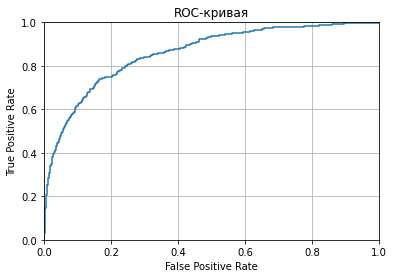

In [22]:
probabilities_valid = model.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_valid[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid()
plt.show() 

Благодаря увеличению целевой выборки в 5 раз (попробовал еще 3-4-5-6, примерно такие же результаты дала 3х кратно увеличенная выборка, немного меньше показатели, но сбалансировались ошибки, у настоящей модели склонность ошибаться в сторону ложнопозитивных предсказаний)мы добились хороших показателей f1_score, AUC-ROC, так же ROC-кривая говорит о хорошем качестве модели.

## Вывод

При обучении моделей на несбалансированных данных, наши модели имели хороший показатель accurary, но низкий f1_score, также  стремились ошибаться в сторону ложнонегативных предсказаний. Выявлен дисбаланс класса 0.8 к 0.2 в целевой выборке. 
После увеличения целевой выборки в 5 раз соотношение классов стало примерно 1 к 1. (0.561385, 0.438615), после чего модели показали лучшие результаты f1_score, самый высокий показатель дала модель обучаеющего леса: Accuracy: 0.806, recall: 0.722, precision: 0.517, f1_score 0.602, что удовлетворяет наши цели. На тестовой выборке эта модель показала так же хорошие результаты: Accuracy: 0.812,recall: 0.740, precision: 0.528, f1_score 0.616, AUC-ROC финальной модели: 0.785. ROC- кривая так же говорит о хорошем качестве модели- прогнозы модели склоняются к истиннопозитивным, кривая сильно отклоняется от прямой константной модели.